In [1]:
import dash
import dash_html_components as html
import dash_bootstrap_components as dbc
from jupyter_dash import JupyterDash
import dash_core_components as dcc
from dash.dependencies import Output, Input
import pandas as pd
from pathlib import Path
import os
import plotly.graph_objects as go
import plotly.express as px
from dash.exceptions import PreventUpdate

def fig_template():
    fig = go.Figure()
    fig.layout.paper_bgcolor = '#E5ECF6'
    fig.layout.plot_bgcolor = '#E5ECF6'
    return fig
# 
path = Path(os.getcwd())
base_dir = path.parent
data_dir = os.path.join(base_dir, "data")
data_dir

dv_runs = pd.read_csv(os.path.join(data_dir, "dv_runs.csv"), delimiter=',', quotechar='"', header='infer')
bus_cat_hold_loc_parquet = pd.read_parquet(os.path.join(data_dir, 'bus_cat_hold_loc'), engine='pyarrow')
df2_groups_pivoted_100_sorted_cut_imputed = pd.read_parquet(os.path.join(data_dir, 'df2_groups_pivoted_100_sorted_cut_imputed'), engine='pyarrow')

# app = dash.Dash(__name__, external_stylesheets=[dbc.themes.DARKLY])
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.COSMO])

app.layout = html.Div([
    html.H1('Gourmand Database',
        style={'color':'orange',
            'fontSize':'50px'}),
    html.H2('Businesses')
    ,html.Br()
    ,html.Div(id='chain_output'),
    dbc.Tabs([
        dbc.Tab([
            html.Ul([
                html.Li('Counts: '),
                html.Li('Unique: '),
                html.Li('Top Chain: '),
                html.Li('Highest Review Count: '),
            dbc.Col(
                html.Li('Computer screen <--> phone screen'), lg={'size': 3, 'offset': 
                1}, sm={'size': 7, 'offset': 
                5})
            ])
    ], label='Data at a Glance'),
        dbc.Tab([
            html.H2('Daily Review Changes', style={'textAlign': 'center'})
            ,dbc.Row(
                [
                    dbc.Col(
                        [
                            dcc.Dropdown(
                                id='year-dropdown'
                                , options=[{'label': year, 'value': year} for year in bus_cat_hold_loc_parquet['CloseDate'].sort_values().unique()]
                            )
                            ,dcc.Graph(
                                id='review-delta-year-barchart'
                            )
                        ]
                    )
                    ,dbc.Col(
                        [
                            dcc.Dropdown(
                                id='state-dropdown'
                                , options=[{'label': state, 'value': state} for state in bus_cat_hold_loc_parquet['StateName'].sort_values().unique()]
                            )
                            ,dcc.Graph(
                                id='review-delta-state-barchart'
                            )
                        ]
                    )                    

                ]
            )
            ,html.H2(
                'hiya!😀'
                , id='data-heading'
                )
        ],label='Stats on States by Day')
        ,dbc.Tab([
            html.Ul([
                html.Br()
                ,html.Li([
                    'Github Repo: '
                    ,html.A('gourmand-data-pipelines', href='https://github.com/raindata5/gourmand-data-pipelines')
                ])
                ,html.Li(['Source: ',
                html.A('Yelp', href='https://www.yelp.com/developers/documentation/v3')
                ])
            ])
        ], label='Background Information')
    ,dbc.Tab([
        html.Br()
        ,dbc.Row(
            [
            dbc.Col(
                dcc.Dropdown(
                    id = 'dag_state_dropdown_menu', options=[
                    {'label':state.title() , 'value':state} for state in list(dv_runs['dag_state'].unique())
            ]) , md={'size': 12}, lg={'size': 5, 'offset':1}
        )
            ,dbc.Col(
                dcc.Dropdown(
                    id = 'date_dropdown_menu',options=[
                    {'label':date , 'value':date} for date in sorted(list(dv_runs['execution_date'].unique()))
            ]) , md={'size': 12}, lg={'size': 5, 'offset':0} 
        )
            ]
        )

        ,dcc.Graph(id='runtime_chart')
        ], label = 'Airflow Task Graph'
    )
    ,dbc.Tab(
        [
            dcc.Dropdown(
                id="cond-prob-chart1-dccd"
                ,options=[{'label':state, 'value':state} for state in df2_groups_pivoted_100_sorted_cut_imputed.StateName.unique()]
            )
            ,dcc.Graph(
                id='cond-prob-chart1'
            )
            ,html.Br()
            ,dbc.Label("States")
            ,dcc.Dropdown(
                id="cond-prob-chart2-dccd"
                ,options = [{'label':state, 'value':state} for state in df2_groups_pivoted_100_sorted_cut_imputed.StateName.unique()]
                ,multi=True
                ,placeholder='Veuillez choisir un ou plusieurs pays'         
            )
            ,dcc.Graph(
                id='cond-prob-chart2'
            )
        ]
        ,label="Conditional Probabilities"
    )
    ]
    )

    
#     ,dbc.Row(
#             [
#                 dbc.Col('BusinessID',width=1 ),
#                 dbc.Col('BusinessName', width =2)
#                 ]
#             )
]
#     , style={'backgroundColor': '#E5ECF6'}
    
)

@app.callback(Output('runtime_chart','figure'),
             Input('date_dropdown_menu','value'),
             Input('dag_state_dropdown_menu','value'))
def plot_by_state_day(date, state):
    title_date = 'all days'
    title_state = 'all'
    if not date and not state:
        df_sorted = dv_runs.sort_values(['runtime_seconds'], ascending=False)
    elif state and not date :
        df = dv_runs.loc[dv_runs['dag_state'] == state]
        title_state = state
        df_sorted = df.sort_values(['runtime_seconds'], ascending=False)
    elif not state and date:
        df = dv_runs.loc[dv_runs['execution_date'] == date]
        df_sorted = df.sort_values(['runtime_seconds'], ascending=False)
        title_date = date
    else:
        df = dv_runs.loc[(dv_runs['dag_state'] == state) & (dv_runs['execution_date'] == date)]
        df_sorted = df.sort_values(['runtime_seconds'], ascending=False)
        title_state = state
        title_date = date
    fig = go.Figure()
    fig.add_bar(x=df_sorted['dag_id'], y=df_sorted['runtime_seconds'])
    fig.layout.title = f'airflow tasks runtimes for {title_date} and for {title_state} attempts'
    fig.layout.yaxis.title = 'runtime (seconds)'
    fig.layout.template = "ggplot2"
    return fig
@app.callback(
    Output('review-delta-year-barchart', 'figure')
    ,Input('year-dropdown', 'value')
)
def plot_by_year(year):
    if not year:
        raise PreventUpdate
    state_day_groups = bus_cat_hold_loc_parquet.groupby(['StateName', 'CloseDate'], as_index=False).sum()
    df=state_day_groups[state_day_groups['CloseDate'] == year].sort_values('abs_review_diff').reset_index(drop=True)
    pixel_constant= df.shape[0]
    fig = px.bar(df, y='StateName',x='abs_review_diff', title=' - '.join(['abs_review_diff', 'by State']),  orientation='h', height=200 + (20 * pixel_constant))

    return fig

@app.callback(
    Output('review-delta-state-barchart', 'figure')
    ,Input('state-dropdown', 'value')
)
def plot_by_state_day(state):
    if not state:
        raise PreventUpdate
    state_day_groups = bus_cat_hold_loc_parquet.groupby(['StateName', 'CloseDate'], as_index=False).sum()
    df=state_day_groups[state_day_groups['StateName'] == state].sort_values('abs_review_diff').reset_index(drop=True)
    pixel_constant= df.shape[0]
    fig = px.bar(df, x='CloseDate',y='abs_review_diff', title=' - '.join([f'abs_review_diff for {state}', 'each day']))

    return fig
@app.callback(
    Output('cond-prob-chart1', 'figure')
    ,Input('cond-prob-chart1-dccd', 'value')
)
def cond_prob_1(state):
    if not state:
        raise PreventUpdate
    # TODO: have a separate dataframe be placed in when no state is selected
    fig = px.bar((df2_groups_pivoted_100_sorted_cut_imputed[df2_groups_pivoted_100_sorted_cut_imputed['StateName']==state] if state else df2_groups_pivoted_100_sorted_cut_imputed),
    x=['one','two','three','four','five'],
    y='PaymentLevelName',
    hover_name='StateName',
    orientation='h',
    barmode='stack',
    height=600 ,
    title=(f'Ratings by Payment level - {state}' if state else 'Ratings by Payment level'))
    
    fig.layout.legend.orientation = 'h'
    fig.layout.legend.title = 'Rating'
    # fig.layout.legend.title = None
    fig.layout.xaxis.title = "Percent of Total Ratings"
    fig.layout.legend.x = 0.25
    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    ))
    return fig
@app.callback(
    Output('cond-prob-chart2', 'figure')
    ,Input("cond-prob-chart2-dccd", 'value')
)
def cond_prob_2(states):
    if not states:
        raise PreventUpdate
    df = df2_groups_pivoted_100_sorted_cut_imputed.loc[df2_groups_pivoted_100_sorted_cut_imputed['StateName'].isin(states)]
    fig = px.bar(
    df,
    x=['one','two','three','four','five'],
    y='PaymentLevelName',
    facet_row = 'StateName',
    hover_name='StateName',
    orientation='h',
    barmode='stack',
    height=100 + 250*len(states),
    labels={'PaymentLevelName': 'PaymentLevelName'},
    title='<br>'.join(['PaymentLevelName', ', '.join(states)])

    )
    fig.layout.legend.title = 'Rating'
    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    ))
    return fig

# make usre to plug in zeros for fig


# if __name__ == '__main__':
# app.run_server(mode='jupyterlab')

app.run_server(mode='jupyterlab')

KeyboardInterrupt: 

In [ ]:
state = None
(df2_groups_pivoted_100_sorted_cut_imputed[df2_groups_pivoted_100_sorted_cut_imputed['StateName']==state] if state else print('hello'))

In [ ]:
dv_runs.dag_id.value_counts().to_frame().style.background_gradient('cividis')

In [ ]:
bus_cat_dataframe = pd.read_csv(os.path.join(data_dir, 'bus_cat.csv'),sep='|', low_memory=True)

In [ ]:
bus_cat_dataframe.CountryName.value_counts()

In [ ]:
from unicodedata import lookup
import numpy as np
def country_flag(letters):
    if not letters:
        return np.nan
    lookup_string1  = f'REGIONAL INDICATOR SYMBOL LETTER {letters[0]}'
    lookup_string2 = f'REGIONAL INDICATOR SYMBOL LETTER {letters[1]}'
#     L0 = lookup(f'REGIONAL INDICATOR SYMBOL LETTER {letters[0]}')
#     L1 = lookup(f'REGIONAL INDICATOR SYMBOL LETTER {letters[1]}')
    L0 = lookup(str.strip(lookup_string1))
    L1 = lookup(str.strip(lookup_string2))
    return L0 + L1


In [ ]:
bus_cat_dataframe['flag'] = [country_flag(code) for code in bus_cat_dataframe['CountryName']]

In [ ]:
bus_cat_dataframe.head()

In [ ]:

bus_cat_dataframe.flag.value_counts()

In [ ]:
holdings = pd.read_csv(os.path.join(data_dir, 'holding.csv'),sep='|', low_memory=True)

In [ ]:
holdings

In [ ]:
county_growth_est = pd.read_csv(os.path.join(data_dir, 'county_growth_est.csv'),sep='|', low_memory=True)

In [ ]:
county_growth_est

In [ ]:
bus_cat_hold = pd.merge(left=bus_cat_dataframe, right=holdings, on='BusinessName', suffixes=[None, 'hodl'])
bus_cat_hold

In [ ]:
bus_cat_hold_loc = pd.merge(left=bus_cat_hold, right=county_growth_est, on=['StateName', 'CountyName'], suffixes=[None, 'hodl'], how='left')

In [ ]:
bus_cat_hold_loc.to_parquet(os.path.join(data_dir, 'bus_cat_hold_loc'), compression='gzip', engine='pyarrow')

In [ ]:
bus_cat_hold_loc.to_csv(os.path.join(data_dir, 'bus_cat_hold_loc.csv'), sep='|', index=False, quotechar="'")

In [29]:
bus_cat_hold_loc_parquet = pd.read_parquet(os.path.join(data_dir, 'bus_cat_hold_loc'), engine='pyarrow')
bus_cat_hold_loc_parquet

,BusinessKey,BusinessName,ChainName,PaymentLevelName,Longitude,Latitude,BusinessCategoryName,CityName,CountyName,StateName,...,previous_rating,abs_review_diff,abs_rating_diff,total_review_cnt_delta,total_bus_rating_delta,EstimationYear,EstimatedPopulation,lastpop,relative_delta,abs_delta
0,23,eastern-shore-street-eats-daphne,Eastern Shore Street Eats,Unknown,-87.868675,30.614799,American (Traditional),Daphne,Baldwin County,Alabama,...,NaN,NaN,NaN,0.0,0.0,2019.0,223234.0,217855.0,0.024691,5379.0
1,23,eastern-shore-street-eats-daphne,Eastern Shore Street Eats,Unknown,-87.868675,30.614799,American (Traditional),Daphne,Baldwin County,Alabama,...,5.0,0.0,0.0,0.0,0.0,2019.0,223234.0,217855.0,0.024691,5379.0
2,23,eastern-shore-street-eats-daphne,Eastern Shore Street Eats,Unknown,-87.868675,30.614799,American (Traditional),Daphne,Baldwin County,Alabama,...,5.0,0.0,0.0,0.0,0.0,2019.0,223234.0,217855.0,0.024691,5379.0
3,23,eastern-shore-street-eats-daphne,Eastern Shore Street Eats,Unknown,-87.868675,30.614799,American (Traditional),Daphne,Baldwin County,Alabama,...,5.0,0.0,0.0,0.0,0.0,2019.0,223234.0,217855.0,0.024691,5379.0
4,23,eastern-shore-street-eats-daphne,Eastern Shore Street Eats,Unknown,-87.868675,30.614799,American (Traditional),Daphne,Baldwin County,Alabama,...,5.0,0.0,0.0,0.0,0.0,2019.0,223234.0,217855.0,0.024691,5379.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019912,63221,rendezvous-meadows-golf-course-pinedale,Rendezvous Meadows Golf Course,Unknown,-109.879516,42.862875,Golf,Pinedale,Sublette County,Wyoming,...,4.0,0.0,0.0,0.0,0.0,2019.0,9831.0,9798.0,0.003368,33.0
1019913,63221,rendezvous-meadows-golf-course-pinedale,Rendezvous Meadows Golf Course,Unknown,-109.879516,42.862875,Golf,Pinedale,Sublette County,Wyoming,...,4.0,0.0,0.0,0.0,0.0,2019.0,9831.0,9798.0,0.003368,33.0
1019914,63221,rendezvous-meadows-golf-course-pinedale,Rendezvous Meadows Golf Course,Unknown,-109.879516,42.862875,Golf,Pinedale,Sublette County,Wyoming,...,4.0,0.0,0.0,0.0,0.0,2019.0,9831.0,9798.0,0.003368,33.0
1019915,63221,rendezvous-meadows-golf-course-pinedale,Rendezvous Meadows Golf Course,Unknown,-109.879516,42.862875,Golf,Pinedale,Sublette County,Wyoming,...,4.0,0.0,0.0,0.0,0.0,2019.0,9831.0,9798.0,0.003368,33.0


In [ ]:
import re
the_columns = list(filter(lambda x: re.search(r'^((?!hodl).)*$', x), bus_cat_hold_loc_parquet.columns))
the_columns


In [ ]:
bus_cat_hold_loc_parquet = bus_cat_hold_loc_parquet.loc[:, the_columns]
bus_cat_hold_loc_parquet

In [ ]:
bus_cat_hold_loc_parquet.to_parquet(os.path.join(data_dir, 'bus_cat_hold_loc'), compression='gzip', engine='pyarrow')

In [ ]:
import plotly.graph_objects as go


In [ ]:
fig = go.Figure()


In [ ]:
fig.add_scatter(x=[1, 2, 3], y=[4, 2, 3])
fig.add_scatter(x=[1, 2, 3, 4], y=[4, 5, 2, 3])


In [ ]:
fig.layout.title = 'Plotly Graph Title'
fig.layout.xaxis.title = 'xaxis title'
fig.layout.yaxis.title = 'yaxis title'

In [ ]:
fig.write_html('html_plot.html',
 config={'toImageButtonOptions':
 {'format': 'svg'}})

In [ ]:
fig.write_image('image_file.svg',
 height=600, width=850)

In [ ]:
fig.show()

In [ ]:
fig.show('json')

In [ ]:

bus_cat_hold_loc_parquet = pd.read_parquet(os.path.join(data_dir, 'bus_cat_hold_loc'), engine='pyarrow')
bus_cat_hold_loc_parquet


In [5]:
state_groups = bus_cat_hold_loc_parquet.groupby(['StateName'], as_index=False).sum()
state_groups

,StateName,BusinessKey,Longitude,Latitude,BusinessRating,ReviewCount,previous_review_cnt,previous_rating,abs_review_diff,abs_rating_diff,total_review_cnt_delta,total_bus_rating_delta,EstimationYear,EstimatedPopulation,lastpop,relative_delta,abs_delta
0,ABE,24,-2.595093e+03,8.231635e+02,96.0,24,21.0,84.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.0
1,Alabama,5781807,-1.281280e+06,4.841840e+05,56055.5,603143,537767.0,49943.5,489.0,-7.5,4772.0,-73.0,29628825.0,1.364135e+09,1.358979e+09,35.635176,5155628.0
2,Alaska,6285814,-8.865640e+05,3.727288e+05,26047.0,698856,620014.0,23133.0,412.0,1.0,3684.0,9.0,12685377.0,4.313563e+08,4.331917e+08,-1.032500,-1835431.0
3,Arizona,13309678,-1.028918e+06,3.118850e+05,37133.5,1485909,1320265.0,32991.0,1415.0,2.0,12729.0,18.0,17763162.0,6.174245e+09,6.070595e+09,105.192380,103650391.0
4,Arkansas,29071039,-1.272199e+06,4.841256e+05,50574.5,567108,501673.0,44857.5,579.0,10.5,5040.0,94.5,26456976.0,1.000633e+09,9.991709e+08,-33.786442,1461875.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,West Virginia,590760346,-7.876860e+05,3.767052e+05,37399.5,396076,346448.0,32722.0,343.0,-6.0,2744.0,-48.0,19079550.0,4.764604e+08,4.809089e+08,-89.234905,-4448438.0
67,Wisconsin,1901504933,-2.744482e+06,1.356179e+06,121743.0,2158834,1887703.0,106490.5,1607.0,6.0,12872.0,48.0,59827008.0,3.873626e+09,3.863130e+09,64.742462,10495452.0
68,Wyoming,436476301,-7.416873e+05,2.955493e+05,28056.5,295303,258180.0,24515.5,269.0,-1.5,2152.0,-12.0,13694877.0,2.232607e+08,2.226219e+08,-15.220824,638845.0
69,XGL,506528,5.856000e-01,4.112859e+02,32.0,24,21.0,28.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.0


In [4]:
state_day_groups = bus_cat_hold_loc_parquet.groupby(['StateName', 'CloseDate'], as_index=False).sum() 

In [ ]:
bus_cat_hold_loc_parquet.info()

In [ ]:
df2 = bus_cat_hold_loc_parquet
df2['rating_groups'] =  df2['BusinessRating'].map(round)

df2_groups = df2.groupby(['rating_groups', 'PaymentLevelName','StateName'],as_index=False).agg({'ReviewCount': 'sum'})
df2_groups_pivoted = df2_groups.pivot(index=['PaymentLevelName', 'StateName'], columns = 'rating_groups', values='ReviewCount')
pd.options.display.float_format = '{:,.4f}'.format
df2_groups_pivoted_100 = df2_groups_pivoted.div(df2_groups_pivoted.sum(axis=1), axis=0)
df2_groups_pivoted_100

In [ ]:
list(df2_groups_pivoted_100.index)[:5]

In [ ]:
df2_groups_pivoted_100_sorted = df2_groups_pivoted_100.rename({'High':'4_High', 'Low':'3_Low', 'Unknown':'1_Unknown', 'Very High':'5_Very High', 'Very Low':'2_Very Low'}, axis=0).sort_index()
df2_groups_pivoted_100_sorted

In [ ]:
df2_groups_pivoted_100_sorted_cut = df2_groups_pivoted_100_sorted.reset_index()
df2_groups_pivoted_100_sorted_cut.columns = ['PaymentLevelName', 'StateName', 'one', 'two', 'three', 'four', 'five']
df2_groups_pivoted_100_sorted_cut

In [ ]:
df2_groups_pivoted_100_sorted_cut.to_parquet(os.path.join(data_dir, 'df2_groups_pivoted_100_sorted_cut'), compression='gzip', engine='pyarrow')

In [ ]:
df2_groups_pivoted_100_sorted_cut_imputed = df2_groups_pivoted_100_sorted_cut.fillna(0)
df2_groups_pivoted_100_sorted_cut_imputed

In [ ]:
df2_groups_pivoted_100_sorted_cut_imputed.to_parquet(os.path.join(data_dir, 'df2_groups_pivoted_100_sorted_cut_imputed'), compression='snappy', engine='pyarrow')

In [2]:
df2_groups_pivoted_100_sorted_cut_imputed.isna().sum()

PaymentLevelName    0
StateName           0
one                 0
two                 0
three               0
four                0
five                0
dtype: int64

In [ ]:

df2_groups_pivoted_100_sorted_cut[df2_groups_pivoted_100_sorted_cut['StateName']=='Florida']

In [ ]:
fig = px.bar(df2_groups_pivoted_100_sorted_cut[df2_groups_pivoted_100_sorted_cut['StateName']=='New York'],
 x=[1,2,3,4,5],
 y='PaymentLevelName',
 hover_name='StateName',
 orientation='h',
 barmode='stack',
 height=20 + (20*df2_groups_pivoted_100_sorted_cut[df2_groups_pivoted_100_sorted_cut['StateName']=='New York'].shape[0]),
 title=f'Ratings by Payment level - Florida')
fig.layout.legend.orientation = 'h'
fig.layout.legend.title = 'Rating'
# fig.layout.legend.title = None
fig.layout.xaxis.title = "Percent of Total Ratings"
fig.layout.legend.x = 0.25
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [ ]:
states = ['Florida', 'Texas', 'New York', 'California']

df = df2_groups_pivoted_100_sorted_cut_imputed.loc[df2_groups_pivoted_100_sorted_cut_imputed['StateName'].isin(states)]
fig = px.bar(
    df,
    x=['one','two','three','four','five'],
    y='PaymentLevelName',
    facet_row = 'StateName',
    hover_name='StateName',
    orientation='h',
    barmode='stack',
    height=100 + 250*len(states),
    labels={'PaymentLevelName': 'PaymentLevelName'},
    title='<br>'.join(['PaymentLevelName', ', '.join(states)])

)
fig.layout.legend.title = 'Rating'
fig.update_layout(legend=dict(
orientation="h",
yanchor="bottom",
y=1.02,
xanchor="right",
x=1
))
fig.show()

In [ ]:
state = 'Florida'

state_date_df = bus_cat_hold_loc_parquet.groupby(['StateName', 'CloseDate'], as_index=False)['ReviewCount'].sum()
state_date_df_filter = state_date_df[state_date_df.StateName == state]
state_date_df_filter

In [ ]:
fig = go.Figure()
fig.add_scatter(x=state_date_df_filter['CloseDate'], y=state_date_df_filter['ReviewCount'], mode='lines+markers+text')
fig.show()

In [ ]:
states = ['Florida', 'Texas', 'Alaska']

state_date_df = bus_cat_hold_loc_parquet.groupby(['StateName', 'CloseDate'], as_index=False)['ReviewCount'].sum()
state_date_df_filter = state_date_df[state_date_df.StateName.isin(states)]
state_date_df_filter



In [ ]:
fig = go.Figure()
for state in states:
    df_trace = state_date_df[state_date_df.StateName.isin([state])]
    fig.add_scatter(x=df_trace['CloseDate'], y=df_trace['ReviewCount'], name=state, mode='lines+markers')

fig.layout.yaxis.title = 'Review Counts'
fig.show()

In [ ]:


fig = px.scatter(state_date_df_filter, x='CloseDate', y='ReviewCount', color='StateName')

figlines = px.line(state_date_df_filter, x='CloseDate', y='ReviewCount', color='StateName')

for trace in figlines.data:
    trace.showlegend = False
    fig.add_trace(trace)
fig.show()

,PaymentLevelName,StateName,one,two,three,four,five
0,1_Unknown,ABE,0.000000,0.000000,0.000000,1.000000,0.000000
1,1_Unknown,Alabama,0.010613,0.083007,0.056837,0.699365,0.150179
2,1_Unknown,Alaska,0.002301,0.019942,0.030066,0.633993,0.313698
3,1_Unknown,Arizona,0.000278,0.007345,0.028779,0.554480,0.409117
4,1_Unknown,Arkansas,0.007081,0.066461,0.050887,0.745777,0.129793
...,...,...,...,...,...,...,...
274,5_Very High,Vermont,0.000000,0.000000,0.000000,1.000000,0.000000
275,5_Very High,Virginia,0.000000,0.000000,0.000000,0.867377,0.132623
276,5_Very High,Washington,0.000000,0.000000,0.000000,0.578342,0.421658
277,5_Very High,West Virginia,0.000000,0.000000,0.000000,1.000000,0.000000


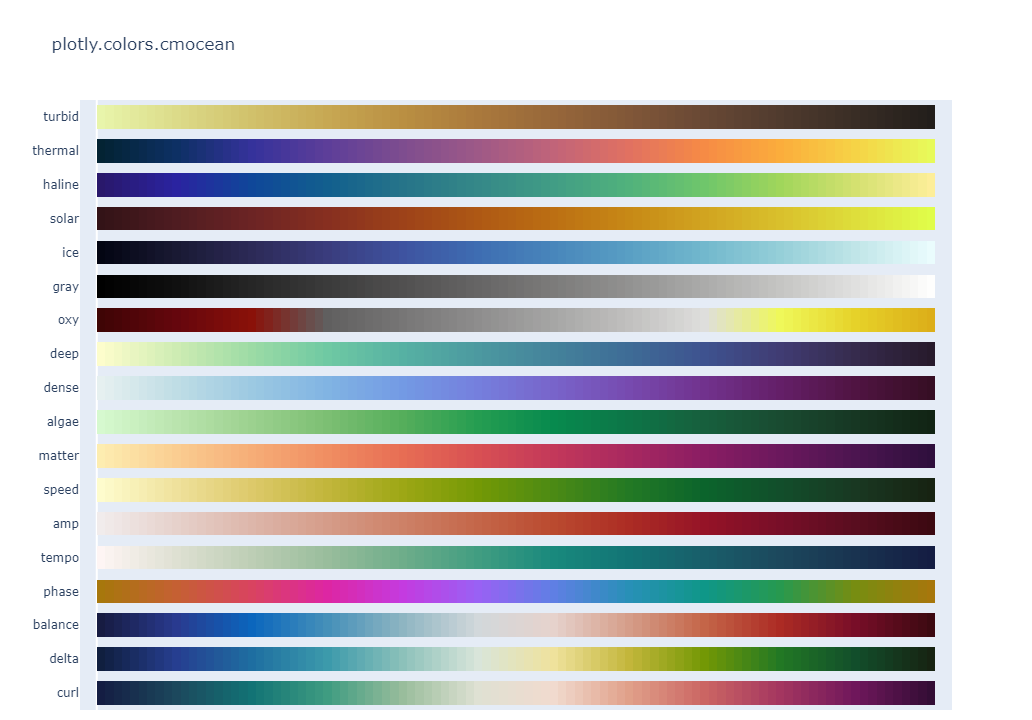

In [24]:
px.colors.cmocean.swatches_continuous()

In [22]:
px.colors.sequential.Electric

['rgb(0,0,0)',
 'rgb(30,0,100)',
 'rgb(120,0,100)',
 'rgb(160,90,0)',
 'rgb(230,200,0)',
 'rgb(255,250,220)']

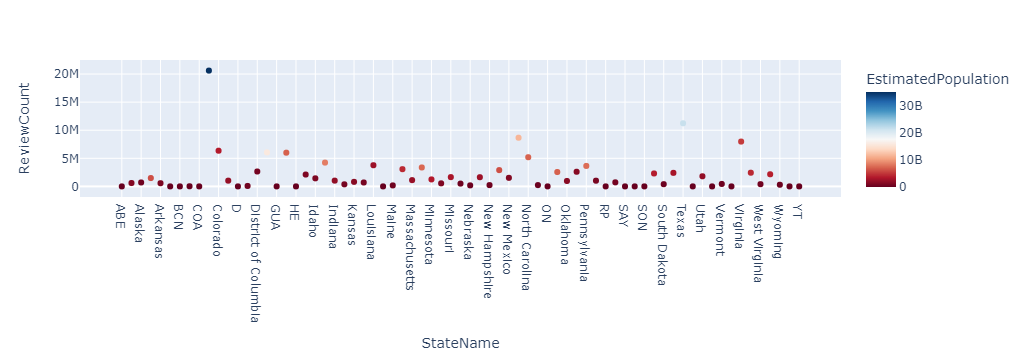

In [14]:
date = '2022-01-13'
y = 'ReviewCount'

px.scatter(
    state_groups,
    x='StateName',
    y='ReviewCount',
    color='EstimatedPopulation',
#     color_continuous_scale=px.colors.cmocean.thermal
    color_continuous_scale='RdBu'
    
    
)

In [3]:
pops = pd.read_csv(os.path.join(data_dir, "county_growth_est.csv"), delimiter='|')
pops_grouped = pops.groupby(['StateName']).agg({'EstimatedPopulation':'sum', 'abs_delta':sum})
pops_grouped.reset_index(inplace=True)
pops_grouped
pops

,StateName,CountyName,EstimationYear,EstimatedPopulation,lastpop,relative_delta,abs_delta
0,California,Siskiyou County,2019,43539,43550,-0.000253,-11
1,Colorado,Saguache County,2019,6824,6840,-0.002339,-16
2,Indiana,Madison County,2019,129569,129573,-0.000031,-4
3,Kansas,Franklin County,2019,25544,25625,-0.003161,-81
4,Kentucky,Green County,2019,10941,10998,-0.005183,-57
...,...,...,...,...,...,...,...
3215,South Dakota,Jones County,2019,903,928,-0.026940,-25
3216,Tennessee,Hardeman County,2019,25050,25276,-0.008941,-226
3217,Texas,Scurry County,2019,16703,16812,-0.006483,-109
3218,Wisconsin,Pierce County,2019,42754,42592,0.003804,162


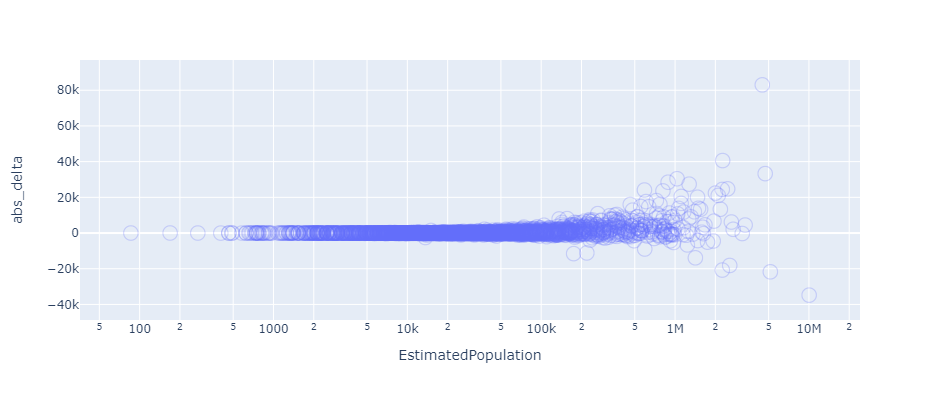

In [12]:
fig = px.scatter(
    pops,
    x='EstimatedPopulation',
    y='abs_delta',
   
#     color_continuous_scale=px.colors.cmocean.thermal
    height=400,
    opacity=.25 ,size=[5]*len(pops), size_max=15,
    log_x=True,
    symbol_sequence=["circle-open"]
    
    
)

fig.show()

In [24]:
df2_groups_pivoted_100_sorted_cut_imputed.PaymentLevelName.value_counts()

1_Unknown      67
3_Low          60
2_Very Low     57
4_High         55
5_Very High    40
Name: PaymentLevelName, dtype: int64

In [15]:
app = JupyterDash(__name__)
app.layout = html.Div([
    dcc.Slider(
        min=0
        ,max=10
        ,step=1
        ,dots=True
        ,included=False
        ,value=5
    )
])
app.run_server(mode='inline')

In [5]:
electric1 = px.colors.sequential.Electric[0]
app.layout = html.Div([
    dcc.Slider(
        id='payment-lvl-slider', min=0, max=5, step=1, dots=True, included=False, value=5, marks={
            0: {'label': 'Unknown', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            1: {'label': 'Very Low', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            2: {'label': 'Low', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            3: {'label': 'High', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            4: {'label': 'Very High', 'style': {'color': electric1, 'fontWeight': 'bold'}}
        }
    )
])
app.run_server(mode='external')

Dash app running on http://127.0.0.1:8050/


In [6]:
bus_cat_hold_loc_parquet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019917 entries, 0 to 1019916
Data columns (total 27 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   BusinessKey             1019917 non-null  int64  
 1   BusinessName            1019917 non-null  object 
 2   ChainName               1019917 non-null  object 
 3   PaymentLevelName        1019917 non-null  object 
 4   Longitude               1019909 non-null  float64
 5   Latitude                1019909 non-null  float64
 6   BusinessCategoryName    1019917 non-null  object 
 7   CityName                1019917 non-null  object 
 8   CountyName              1019917 non-null  object 
 9   StateName               1019917 non-null  object 
 10  CountryName             1019917 non-null  object 
 11  flag                    1019917 non-null  object 
 12  ChainNamehodl           1019917 non-null  object 
 13  BusinessRating          1019917 non-null  float64
 14  Re

In [3]:
unix_format = '%s'
format = "%Y-%m-%d"
datetime.datetime.strptime('2022-01-13', format).strftime(unix_format)

'1642050000'

In [4]:
def to_unix_or_reg(the_date: str, the_format: str, option: str):
    unix_format = '%s'
    if option == 'unix':
        new_date = datetime.datetime.strptime(the_date, the_format).strftime(unix_format)
    elif option == 'reg':
        new_date = datetime.datetime.strptime(the_date, the_format).strftime(the_format)
    else:
        print('no good option')
        exit(0)
    return new_date

In [10]:
# the value can't be a string
electric1 = px.colors.sequential.Electric[0]
days = sorted(bus_cat_hold_loc_parquet.CloseDate.unique())
format = "%Y-%m-%d"

unix_format = '%s'

app.layout = html.Div([
    dcc.Slider(
        id='payment-lvl-slider', min=0, max=4, step=1, dots=True, included=False, value=5, marks={
            0: {'label': 'Unknown', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            1: {'label': 'Very Low', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            2: {'label': 'Low', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            3: {'label': 'High', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            4: {'label': 'Very High', 'style': {'color': electric1, 'fontWeight': 'bold'}}
        }
    )
    ,dcc.Slider(
        id='close-data-slider'
        ,min=int(to_unix_or_reg(days[0], format, 'unix'))
        ,max=int(to_unix_or_reg(days[-1], format, 'unix'))
        ,step=1
        ,dots=True
        ,included=False
        ,value= int(to_unix_or_reg('2022-01-13', format, 'unix'))
        ,marks= {int(to_unix_or_reg(day, format, 'unix')): {'label': to_unix_or_reg(day, format, 'reg'), 'style':{'color': electric1, 'fontWeight':'bold'}}  for day in days}
    )
    , dcc.Graph(
        id='slider-graph'
    )
])
@app.callback(
    Output('slider-graph', 'figure')
    ,Input('payment-lvl-slider', 'value')
    ,Input('close-data-slider', 'value')
)
def plot_day_payment_lvl(lvl, day):
    day = bus_cat_hold_loc_parquet.loc[(bus_cat_hold_loc_parquet['PaymentLevelName'] == lvl) & (bus_cat_hold_loc_parquet['CloseDate'] == day)]
    fig = go.Figure()
    fig.layout.xaxis.title = lvl
    fig.layout.yaxis.title = day
    return fig
app.run_server(mode='external')

Dash app running on http://127.0.0.1:8050/


In [6]:
import dash
import dash_html_components as html
import dash_bootstrap_components as dbc
from jupyter_dash import JupyterDash
import dash_core_components as dcc
from dash.dependencies import Output, Input
import pandas as pd
from pathlib import Path
import os
import plotly.graph_objects as go
import plotly.express as px
from dash.exceptions import PreventUpdate
import datetime
from typing import Union
import numpy as np
from random import choices

def fig_template():
    fig = go.Figure()
    fig.layout.paper_bgcolor = '#E5ECF6'
    fig.layout.plot_bgcolor = '#E5ECF6'
    return fig

def to_unix_or_reg(the_date: Union[str, int], the_format: str, option: str):
    unix_format = '%s'
    if option == 'unix':
        new_date = datetime.datetime.strptime(the_date, the_format).strftime(unix_format)
    elif option == 'reg':
        new_date = datetime.datetime.strptime(the_date, unix_format).strftime(the_format)
    elif option =='unix_reg':
        new_date = datetime.datetime.fromtimestamp(the_date).strftime(the_format)
    else:
        print('no good option')
        exit(0)
    return new_date


path = Path(os.getcwd())
base_dir = path.parent
data_dir = os.path.join(base_dir, "data")
data_dir

dv_runs = pd.read_csv(os.path.join(data_dir, "dv_runs.csv"), delimiter=',', quotechar='"', header='infer')
bus_cat_hold_loc_parquet = pd.read_parquet(os.path.join(data_dir, 'bus_cat_hold_loc'), engine='pyarrow')
df2_groups_pivoted_100_sorted_cut_imputed = pd.read_parquet(os.path.join(data_dir, 'df2_groups_pivoted_100_sorted_cut_imputed'), engine='pyarrow')
electric1 = px.colors.sequential.Electric[0]
days = sorted(bus_cat_hold_loc_parquet.CloseDate.unique().tolist())
the_format = "%Y-%m-%d"
unix_format = '%s'

# app = dash.Dash(__name__, external_stylesheets=[dbc.themes.DARKLY])
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.COSMO])

app.layout = html.Div([
    html.H1('Gourmand Database',
        style={'color':'orange',
            'fontSize':'50px'}),
    html.H2('Businesses')
    ,html.Br()
    ,html.Div(id='chain_output'),
    dbc.Tabs([
        dbc.Tab([
            html.Ul([
                html.Li('Counts: '),
                html.Li('Unique: '),
                html.Li('Top Chain: '),
                html.Li('Highest Review Count: '),
            dbc.Col(
                html.Li('Computer screen <--> phone screen'), lg={'size': 3, 'offset': 
                1}, sm={'size': 7, 'offset': 
                5})
            ])
    ], label='Data at a Glance'),
        dbc.Tab([
            html.H2('Daily Review Changes', style={'textAlign': 'center'})
            ,dbc.Row(
                [
                    dbc.Col(
                        [
                            dcc.Dropdown(
                                id='year-dropdown'
                                , options=[{'label': year, 'value': year} for year in bus_cat_hold_loc_parquet['CloseDate'].sort_values().unique()]
                            )
                            ,dcc.Graph(
                                id='review-delta-year-barchart'
                            )
                        ]
                    )
                    ,dbc.Col(
                        [
                            dcc.Dropdown(
                                id='state-dropdown'
                                , options=[{'label': state, 'value': state} for state in bus_cat_hold_loc_parquet['StateName'].sort_values().unique()]
                            )
                            ,dcc.Graph(
                                id='review-delta-state-barchart'
                            )
                        ]
                    )                    

                ]
            )
            ,html.H2(
                'hiya!😀'
                , id='data-heading'
                )
        ],label='Stats on States by Day')
        ,dbc.Tab([
            html.Ul([
                html.Br()
                ,html.Li([
                    'Github Repo: '
                    ,html.A('gourmand-data-pipelines', href='https://github.com/raindata5/gourmand-data-pipelines')
                ])
                ,html.Li(['Source: ',
                html.A('Yelp', href='https://www.yelp.com/developers/documentation/v3')
                ])
            ])
        ], label='Background Information')
    ,dbc.Tab([
        html.Br()
        ,dbc.Row(
            [
            dbc.Col(
                dcc.Dropdown(
                    id = 'dag_state_dropdown_menu', options=[
                    {'label':state.title() , 'value':state} for state in list(dv_runs['dag_state'].unique())
            ]) , md={'size': 12}, lg={'size': 5, 'offset':1}
        )
            ,dbc.Col(
                dcc.Dropdown(
                    id = 'date_dropdown_menu',options=[
                    {'label':date , 'value':date} for date in sorted(list(dv_runs['execution_date'].unique()))
            ]) , md={'size': 12}, lg={'size': 5, 'offset':0} 
        )
            ]
        )

        ,dcc.Graph(id='runtime_chart')
        ], label = 'Airflow Task Graph'
    )
    ,dbc.Tab(
        [
            dcc.Dropdown(
                id="cond-prob-chart1-dccd"
                ,options=[{'label':state, 'value':state} for state in df2_groups_pivoted_100_sorted_cut_imputed.StateName.unique()]
            )
            ,dcc.Graph(
                id='cond-prob-chart1'
            )
            ,html.Br()
            ,dbc.Label("States")
            ,dcc.Dropdown(
                id="cond-prob-chart2-dccd"
                ,options = [{'label':state, 'value':state} for state in df2_groups_pivoted_100_sorted_cut_imputed.StateName.unique()]
                ,multi=True
                ,placeholder='Veuillez choisir un ou plusieurs pays'         
            )
            ,dcc.Graph(
                id='cond-prob-chart2'
            )
            ,dcc.Slider(
        id='payment-lvl-slider'
                , min=0, max=5, step=1, dots=True, included=False, value=1, marks={
            1: {'label': 'Unknown', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            2: {'label': 'Very Low', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            3: {'label': 'Low', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            4: {'label': 'High', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            5: {'label': 'Very High', 'style': {'color': electric1, 'fontWeight': 'bold'}}
                }
            )
            ,html.Br()
            ,dcc.Slider(
                id='close-data-slider'
                ,min=int(to_unix_or_reg(days[::2][0], the_format, 'unix')) - 86400
                ,max=int(to_unix_or_reg(days[::2][-1], the_format, 'unix')) + 86400
                ,step=86400
                ,dots=True
                ,included=False
#                 ,value= int(to_unix_or_reg('2022-01-13', format, 'unix'))
                ,tooltip= {"placement": "top", "always_visible": True}
                ,marks= {int(to_unix_or_reg(day, the_format, 'unix')): {'label': day, 'style':{'color': electric1, 'fontWeight':'bold'}}  for day in days[::2]}
            )
            , dcc.Graph(
                id='slider-graph'
            )
        ]
        ,label="Conditional Probabilities"
    )
    ]
    )

]

    
)

@app.callback(Output('runtime_chart','figure'),
             Input('date_dropdown_menu','value'),
             Input('dag_state_dropdown_menu','value'))
def plot_by_state_day(date, state):
    title_date = 'all days'
    title_state = 'all'
    if not date and not state:
        df_sorted = dv_runs.sort_values(['runtime_seconds'], ascending=False)
    elif state and not date :
        df = dv_runs.loc[dv_runs['dag_state'] == state]
        title_state = state
        df_sorted = df.sort_values(['runtime_seconds'], ascending=False)
    elif not state and date:
        df = dv_runs.loc[dv_runs['execution_date'] == date]
        df_sorted = df.sort_values(['runtime_seconds'], ascending=False)
        title_date = date
    else:
        df = dv_runs.loc[(dv_runs['dag_state'] == state) & (dv_runs['execution_date'] == date)]
        df_sorted = df.sort_values(['runtime_seconds'], ascending=False)
        title_state = state
        title_date = date
    fig = go.Figure()
    fig.add_bar(x=df_sorted['dag_id'], y=df_sorted['runtime_seconds'])
    fig.layout.title = f'airflow tasks runtimes for {title_date} and for {title_state} attempts'
    fig.layout.yaxis.title = 'runtime (seconds)'
    fig.layout.template = "ggplot2"
    return fig

@app.callback(
    Output('review-delta-year-barchart', 'figure')
    ,Input('year-dropdown', 'value')
)
def plot_by_year(year):
    if not year:
        raise PreventUpdate
    state_day_groups = bus_cat_hold_loc_parquet.groupby(['StateName', 'CloseDate'], as_index=False).sum()
    df=state_day_groups[state_day_groups['CloseDate'] == year].sort_values('abs_review_diff').reset_index(drop=True)
    pixel_constant= df.shape[0]
    fig = px.bar(df, y='StateName',x='abs_review_diff', title=' - '.join(['abs_review_diff', 'by State']),  orientation='h', height=200 + (20 * pixel_constant))
    return fig

@app.callback(
    Output('review-delta-state-barchart', 'figure')
    ,Input('state-dropdown', 'value')
)
def plot_by_state_day(state):
    if not state:
        raise PreventUpdate
    state_day_groups = bus_cat_hold_loc_parquet.groupby(['StateName', 'CloseDate'], as_index=False).sum()
    df=state_day_groups[state_day_groups['StateName'] == state].sort_values('abs_review_diff').reset_index(drop=True)
    pixel_constant= df.shape[0]
    fig = px.bar(df, x='CloseDate',y='abs_review_diff', title=' - '.join([f'abs_review_diff for {state}', 'each day']))

    return fig
@app.callback(
    Output('cond-prob-chart1', 'figure')
    ,Input('cond-prob-chart1-dccd', 'value')
)
def cond_prob_1(state):
    if not state:
        raise PreventUpdate
    # TODO: have a separate dataframe be placed in when no state is selected
    fig = px.bar((df2_groups_pivoted_100_sorted_cut_imputed[df2_groups_pivoted_100_sorted_cut_imputed['StateName']==state] if state else df2_groups_pivoted_100_sorted_cut_imputed),
    x=['one','two','three','four','five'],
    y='PaymentLevelName',
    hover_name='StateName',
    orientation='h',
    barmode='stack',
    height=600 ,
    title=(f'Ratings by Payment level - {state}' if state else 'Ratings by Payment level'))
    
    fig.layout.legend.orientation = 'h'
    fig.layout.legend.title = 'Rating'
    # fig.layout.legend.title = None
    fig.layout.xaxis.title = "Percent of Total Ratings"
    fig.layout.legend.x = 0.25
    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    ))
    return fig
@app.callback(
    Output('cond-prob-chart2', 'figure')
    ,Input("cond-prob-chart2-dccd", 'value')
)
def cond_prob_2(states):
    if not states:
        raise PreventUpdate
    df = df2_groups_pivoted_100_sorted_cut_imputed.loc[df2_groups_pivoted_100_sorted_cut_imputed['StateName'].isin(states)]
    fig = px.bar(
    df,
    x=['one','two','three','four','five'],
    y='PaymentLevelName',
    facet_row = 'StateName',
    hover_name='StateName',
    orientation='h',
    barmode='stack',
    height=100 + 250*len(states),
    labels={'PaymentLevelName': 'PaymentLevelName'},
    title='<br>'.join(['PaymentLevelName', ', '.join(states)])

    )
    fig.layout.legend.title = 'Rating'
    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    ))
    return fig
@app.callback(
    Output('slider-graph', 'figure')
    ,Input('payment-lvl-slider', 'drag_value')
    ,Input('payment-lvl-slider', 'marks')
    ,Input('close-data-slider', 'drag_value')
    ,Input('close-data-slider', 'marks')
)
def plot_day_payment_lvl(lvl,lvl_marks, day, day_marks):
    # check out webgl
    if (not lvl) or (not day):
        raise PreventUpdate 
    new_day = to_unix_or_reg(the_date=day, the_format=the_format, option='unix_reg')
    lvl=lvl_marks[str(lvl)]['label']
    day_df = bus_cat_hold_loc_parquet.loc[(bus_cat_hold_loc_parquet['PaymentLevelName'] == lvl) & (bus_cat_hold_loc_parquet['CloseDate'] == new_day)]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=day_df['EstimatedPopulation'], y=day_df['abs_review_diff'], mode='markers', marker_color='rgba(152, 0, 0, .8)', opacity=.50))

    fig.layout.xaxis.title = 'Estimated Population'
    fig.layout.yaxis.title = 'Absolute Review Difference'
    return fig

app.run_server(mode='jupyterlab')

In [35]:
def convert_state_name(name):
    cd=str(name)
    us_state_abbrev = {
    "Alabama":"AL",
    "Alaska":"AK",
    "Arizona":"AZ",
    "Arkansas":"AR",
    "California":"CA",
    "Colorado":"CO",
    "Connecticut":"CT",
    "Delaware":"DE",
    "Washington DC":"DC",
    "Florida":"FL",
    "Georgia":"GA",
    "Hawaii":"HI",
    "Idaho":"ID",
    "Illinois":"IL",
    "Indiana":"IN",
    "Iowa":"IA",
    "Kansas":"KS",
    "Kentucky":"KY",
    "Louisiana":"LA",
   "Maine":"ME"
   , "Maryland":"MD"
    ,"Massachusetts":"MA"
    ,"Michigan":"MI"
    ,"Minnesota":"MN"
    ,"Mississippi":"MS"
    ,"Missouri":"MO"
    ,"Montana":"MT"
    ,"Nebraska":"NE"
    ,"Nevada":"NV"
    ,"New Hampshire":"NH"
    ,"New Jersey":"NJ"
    ,"New Mexico":"NM"
    ,"New York":"NY"
    ,"North Carolina":"NC"
    ,"North Dakota":"ND"
    ,"Ohio":"OH"
    ,"Oklahoma":"OK"
    ,"Oregon":"OR"
    ,"Pennsylvania":"PA"
    ,"Rhode Island":"RI"
    ,"South Carolina":"SC"
    ,"South Dakota":"SD"
    ,"Tennessee":"TN"
    ,"Texas":"TX"
    ,"Utah":"UT"
    ,"Vermont":"VT"
    ,"Virginia":"VA"
    ,"Washington":"WA"
    ,"West Virginia":"WV"
    ,"Wisconsin":"WI"
    ,"Wyoming":"WY"}
    return us_state_abbrev.get(cd, cd)

bus_cat_hold_loc_parquet['state_abrv'] = bus_cat_hold_loc_parquet.StateName.apply(lambda x:convert_state_name(x)) 

In [36]:
country_counts = bus_cat_hold_loc_parquet.groupby(['state_abrv', 'CloseDate'], as_index=False)['abs_review_diff'].sum()
country_counts

,state_abrv,CloseDate,abs_review_diff
0,ABE,2021-12-29,0.0
1,ABE,2022-01-07,0.0
2,ABE,2022-01-08,0.0
3,ABE,2022-01-09,0.0
4,ABE,2022-01-10,0.0
...,...,...,...
613,YT,2022-01-09,0.0
614,YT,2022-01-10,0.0
615,YT,2022-01-11,0.0
616,YT,2022-01-12,0.0


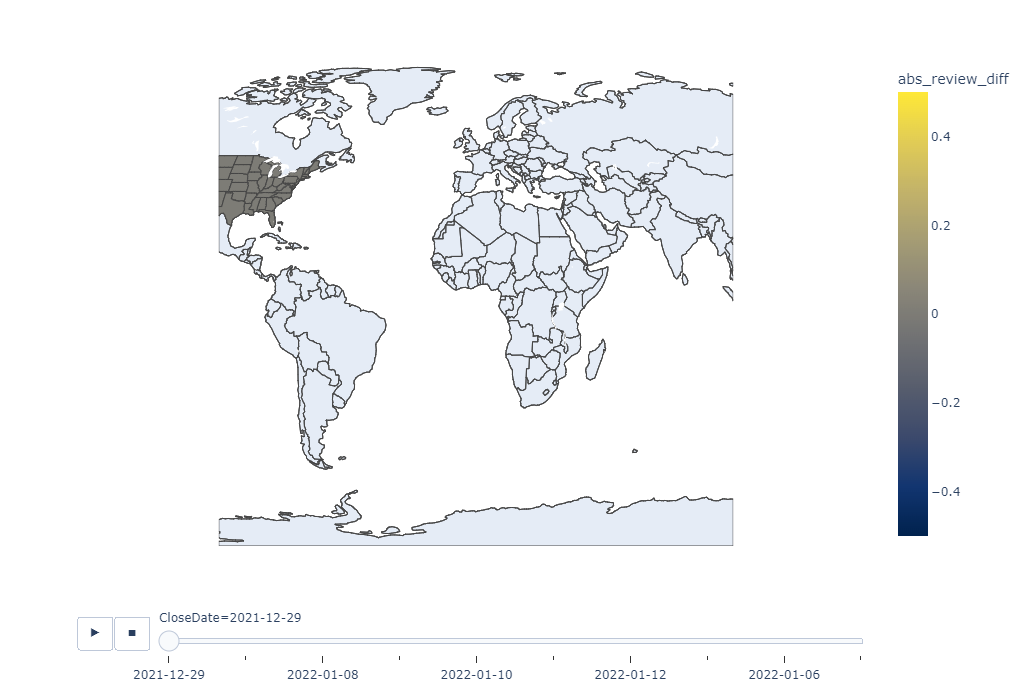

In [50]:
fig= px.choropleth(data_frame=country_counts, locationmode='USA-states', locations='state_abrv' , color='abs_review_diff', color_continuous_scale='cividis', animation_frame='CloseDate', height=700, width=1000)
fig.layout.geo.showframe = False
fig.layout.geo.showsubunits = True
fig.layout.geo.showcountries = True
fig.layout.geo.projection.type = 'natural earth'
fig.layout.geo.lonaxis.range = [-300,300]
fig.show()